In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import os

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

Loading the Dataset

In [4]:
df = pd.read_csv('/content/processed_ipl_data2.csv')
df_matches = pd.read_csv('/content/matches.csv')
df_deliveries = pd.read_csv('/content/deliveries.csv')

In [5]:
df.head()

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,...,method,umpire1,umpire2,is_legal,legal_ball,all_balls_over_ball,adjusted_over_ball,match_number_of_that_season,matches_in_that_season,match_number_in_total
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,...,Normal,Asad Rauf,RE Koertzen,True,1.0,0.1,0.1,1.0,58.0,1.0
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,...,Normal,Asad Rauf,RE Koertzen,True,2.0,0.2,0.2,1.0,58.0,1.0
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,...,Normal,Asad Rauf,RE Koertzen,False,2.0,0.3,0.2,1.0,58.0,1.0
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,...,Normal,Asad Rauf,RE Koertzen,True,3.0,0.4,0.3,1.0,58.0,1.0
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,...,Normal,Asad Rauf,RE Koertzen,True,4.0,0.5,0.4,1.0,58.0,1.0


In [6]:
df_matches.head()

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,IPL-2017,Rajkot,07-04-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,IPL-2017,Indore,08-04-2017,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


In [7]:
df_deliveries.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NaN,NaN,NaN


In [8]:
df.shape

(183604, 44)

In [9]:
df_matches.shape

(756, 18)

In [10]:
df_deliveries.shape

(179078, 21)

In [11]:
#  Data Cleaning & Preprocessing

In [12]:
# Drop unnecessary columns from matches
drop_cols = ['umpire1', 'umpire2', 'umpire3', 'id']
df_matches = df_matches.drop(columns=drop_cols)

In [13]:
# Fill null values in city, winner
df_matches['city'].fillna(method='ffill', inplace=True)
df_matches['winner'].fillna('Draw', inplace=True)

In [14]:
# Standardize team names
team_name_corrections = {
    "Rising Pune Supergiant": "Rising Pune Supergiants",
    "Delhi Daredevils": "Delhi Capitals",
    "Deccan Chargers": "Sunrisers Hyderabad"
}

In [15]:
for col in ['team1', 'team2', 'toss_winner', 'winner']:
   df_matches[col] = df_matches[col].replace(team_name_corrections)

In [16]:
# Same for deliveries dataset
df_deliveries.replace(team_name_corrections, inplace=True)

In [17]:
df.head()

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,...,method,umpire1,umpire2,is_legal,legal_ball,all_balls_over_ball,adjusted_over_ball,match_number_of_that_season,matches_in_that_season,match_number_in_total
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,...,Normal,Asad Rauf,RE Koertzen,True,1.0,0.1,0.1,1.0,58.0,1.0
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,...,Normal,Asad Rauf,RE Koertzen,True,2.0,0.2,0.2,1.0,58.0,1.0
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,...,Normal,Asad Rauf,RE Koertzen,False,2.0,0.3,0.2,1.0,58.0,1.0
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,...,Normal,Asad Rauf,RE Koertzen,True,3.0,0.4,0.3,1.0,58.0,1.0
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,...,Normal,Asad Rauf,RE Koertzen,True,4.0,0.5,0.4,1.0,58.0,1.0


In [18]:
df_matches.head()

,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue
0,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal"
1,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiants,Rising Pune Supergiants,field,normal,0,Rising Pune Supergiants,0,7,SPD Smith,Maharashtra Cricket Association Stadium
2,IPL-2017,Rajkot,07-04-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium
3,IPL-2017,Indore,08-04-2017,Rising Pune Supergiants,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium
4,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Capitals,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium


In [19]:
df_deliveries.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NaN,NaN,NaN


In [20]:
df.shape

(183604, 44)

In [21]:
df_matches.shape

(756, 14)

In [22]:
df_deliveries.shape

(179078, 21)

In [23]:
#  Feature Engineering

In [24]:
# Toss win and match win correlation
df_matches['toss_match_win'] = df_matches['toss_winner'] == df_matches['winner']
df_matches['toss_match_win'] = df_matches['toss_match_win'].astype(int)

In [25]:
# Encode target labels
le = LabelEncoder()
df_matches['winner_encoded'] = le.fit_transform(df_matches['winner'])

In [26]:
# Save label mapping for decoding predictions later
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

In [27]:
# Add result feature
def result_type(row):
    if row['win_by_runs'] > 0:
        return 'Bat'
    elif row['win_by_wickets'] > 0:
        return 'Bowl'
    else:
        return 'Draw'

In [28]:
df_matches['result_type'] = df_matches.apply(result_type, axis=1)

In [29]:
#  EDA: Win Trends

In [30]:
df_matches.columns

Index(['Season', 'city', 'date', 'team1', 'team2', 'toss_winner',
       'toss_decision', 'result', 'dl_applied', 'winner', 'win_by_runs',
       'win_by_wickets', 'player_of_match', 'venue', 'toss_match_win',
       'winner_encoded', 'result_type'],
      dtype='object')

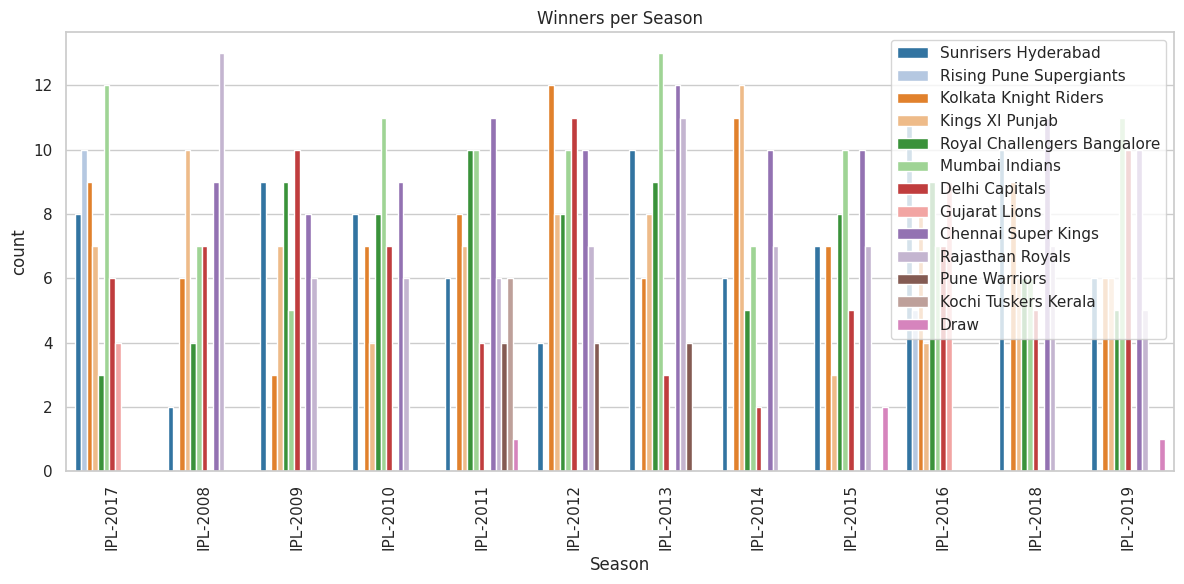

In [31]:
plt.figure(figsize=(12,6))
sns.countplot(data=df_matches, x='Season', hue='winner', palette='tab20')
plt.title("Winners per Season")
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

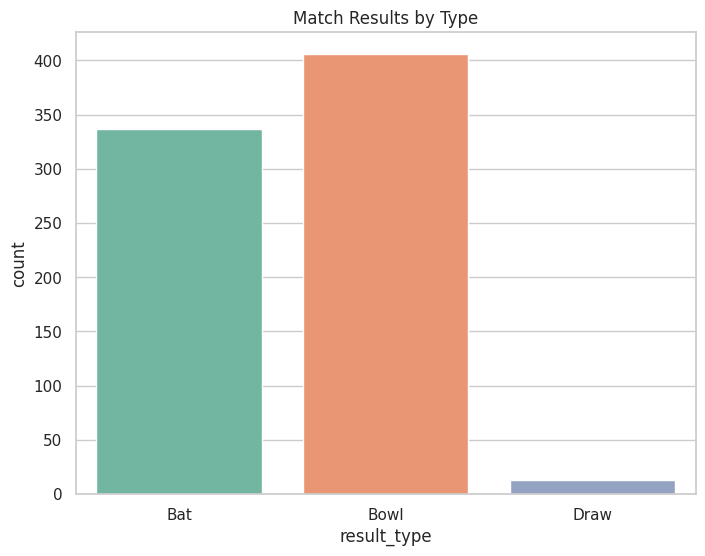

In [32]:
plt.figure(figsize=(8,6))
sns.countplot(data=df_matches, x='result_type', palette='Set2')
plt.title("Match Results by Type")
plt.show()

In [33]:
#  Dataset Preparation for ML

In [34]:
model_data = df_matches[['team1', 'team2', 'toss_winner', 'venue', 'toss_decision', 'Season', 'winner_encoded']]

In [35]:
# Encode categorical features
encoded_data = pd.get_dummies(model_data, columns=['team1', 'team2', 'toss_winner', 'venue', 'toss_decision', 'Season'])

In [36]:
# Split into train/test
X = encoded_data.drop(columns='winner_encoded')
y = encoded_data['winner_encoded']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# After creating your X and y for the model
# ... your existing code ...
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the feature columns
joblib.dump(X.columns.tolist(), 'features.pkl')

['features.pkl']

In [39]:
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
#  Model Building

In [41]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [42]:
print("\nRandom Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.5592105263157895
              precision    recall  f1-score   support

           0       0.74      0.77      0.75        26
           1       0.22      0.20      0.21        10
           3       1.00      1.00      1.00         4
           4       0.40      0.47      0.43        17
           5       0.00      0.00      0.00         0
           6       0.64      0.64      0.64        22
           7       0.50      0.58      0.54        19
           8       0.00      0.00      0.00         4
           9       0.69      0.64      0.67        14
          10       1.00      0.40      0.57         5
          11       0.53      0.75      0.62        12
          12       0.40      0.32      0.35        19

    accuracy                           0.56       152
   macro avg       0.51      0.48      0.48       152
weighted avg       0.56      0.56      0.55       152



In [43]:
# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [44]:
print("\nXGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.5263157894736842
              precision    recall  f1-score   support

           0       0.73      0.62      0.67        26
           1       0.27      0.30      0.29        10
           3       0.80      1.00      0.89         4
           4       0.38      0.53      0.44        17
           5       0.00      0.00      0.00         0
           6       0.60      0.55      0.57        22
           7       0.48      0.53      0.50        19
           8       0.00      0.00      0.00         4
           9       0.57      0.57      0.57        14
          10       1.00      0.60      0.75         5
          11       0.44      0.58      0.50        12
          12       0.57      0.42      0.48        19

    accuracy                           0.53       152
   macro avg       0.49      0.47      0.47       152
weighted avg       0.54      0.53      0.53       152



In [45]:
# LightGBM
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141
[LightGBM] [Info] Number of data points in the train set: 604, number of used features: 47
[LightGBM] [Info] Start training from score -2.099509
[LightGBM] [Info] Start training from score -2.198882
[LightGBM] [Info] Start training from score -5.017280
[LightGBM] [Info] Start training from score -4.206350
[LightGBM] [Info] Start training from score -2.229187
[LightGBM] [Info] Start training from score -4.611815
[LightGBM] [Info] Start training from score -2.155079
[LightGBM] [Info] Start training from score -1.903765
[LightGBM] [Info] Start training from score -4.324133
[LightGBM] [Info] Start training from score -2.292700
[LightGBM] [Info] Start training from score -4.100989
[LightGBM] [Info] Start training from score -2.126908
[L

In [46]:
print("\nLightGBM Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print(classification_report(y_test, y_pred_lgbm))


LightGBM Accuracy: 0.5263157894736842
              precision    recall  f1-score   support

           0       0.72      0.69      0.71        26
           1       0.25      0.30      0.27        10
           3       0.50      1.00      0.67         4
           4       0.47      0.53      0.50        17
           5       0.00      0.00      0.00         0
           6       0.63      0.55      0.59        22
           7       0.43      0.47      0.45        19
           8       0.00      0.00      0.00         4
           9       0.62      0.57      0.59        14
          10       0.00      0.00      0.00         5
          11       0.47      0.75      0.58        12
          12       0.53      0.42      0.47        19

    accuracy                           0.53       152
   macro avg       0.39      0.44      0.40       152
weighted avg       0.51      0.53      0.51       152



In [47]:
#  Hyperparameter Tuning (Random Forest)

In [48]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

In [49]:
gs_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, verbose=1, n_jobs=-1)
gs_rf.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             verbose=1)

In [50]:
print("\nBest Parameters:", gs_rf.best_params_)


Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


In [51]:
# XGBoost Tuning

In [52]:
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6]
}

In [53]:
gs_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), param_grid_xgb, cv=3, verbose=1, n_jobs=-1)
gs_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 6],
                         'n_estimators': [100, 200]},
             verbose=1)

In [54]:
print("\nBest Parameters (XGBoost):", gs_xgb.best_params_)


Best Parameters (XGBoost): {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


In [55]:
# LightGBM Tuning

In [56]:
param_grid_lgbm = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 64]
}

In [57]:
gs_lgbm = GridSearchCV(LGBMClassifier(random_state=42), param_grid_lgbm, cv=3, verbose=1, n_jobs=-1)
gs_lgbm.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141
[LightGBM] [Info] Number of data points in the train set: 604, number of used features: 47
[LightGBM] [Info] Start training from score -2.099509
[LightGBM] [Info] Start training from score -2.198882
[LightGBM] [Info] Start training from score -5.017280
[LightGBM] [Info] Start training from score -4.206350
[LightGBM] [Info] Start training from score -2.229187
[LightGBM] [Info] Start training from score -4.611815
[LightGBM] [Info] Start training from score -2.155079
[LightGBM] [Info] Start training from score -1.903765
[LightGBM] [Info] Start training from score -4.324133
[LightGBM] [Info] Start training from score -2.292700
[LightGBM] [Info] Start training from score -4.100

GridSearchCV(cv=3, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1],
                         'n_estimators': [100, 200], 'num_leaves': [31, 64]},
             verbose=1)

In [58]:
print("\nBest Parameters (LightGBM):", gs_lgbm.best_params_)


Best Parameters (LightGBM): {'learning_rate': 0.01, 'n_estimators': 200, 'num_leaves': 31}


In [59]:
#  Save the Best Model

In [60]:
best_model = gs_rf.best_estimator_
joblib.dump(best_model, 'ipl_match_winner_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')
print("\nModels and encoders saved successfully!")


Models and encoders saved successfully!


In [61]:
#  Prediction Function

In [62]:
def predict_winner(team1, team2, toss_winner, venue, toss_decision, season):
    df = pd.DataFrame([[team1, team2, toss_winner, venue, toss_decision, season]],
                      columns=['team1', 'team2', 'toss_winner', 'venue', 'toss_decision', 'Season'])
    df = pd.get_dummies(df)

In [63]:
    # Align columns
    for col in X.columns:
        if col not in df.columns:
            df[col] = 0
    df = df[X.columns]

In [64]:
# Prepare input dataframe

In [65]:
def load_model_and_predict(input_data_dict):
    model = joblib.load('ipl_match_winner_model.pkl')
    scaler = joblib.load('scaler.pkl')
    encoder = joblib.load('label_encoder.pkl')
    # Prepare input dataframe
    input_df = pd.DataFrame([input_data_dict])
    input_encoded = pd.get_dummies(input_df) # Fixed: Removed extra indentation

    for col in X.columns:
        if col not in input_encoded.columns:
            input_encoded[col] = 0
    input_encoded = input_encoded[X.columns]

    input_scaled = scaler.transform(input_encoded)
    prediction = model.predict(input_scaled)
    predicted_team = encoder.inverse_transform(prediction)

    return predicted_team[0]

In [66]:
print("\nAlternative Example Prediction:")
sample_input = {
    'team1': 'Mumbai Indians',
    'team2': 'Chennai Super Kings',
    'toss_winner': 'Mumbai Indians',
    'venue': 'Wankhede Stadium',
    'toss_decision': 'bat',
    'season': 2020
}

predicted_winner = load_model_and_predict(sample_input)
print("Predicted Winner:", predicted_winner)



Alternative Example Prediction:
Predicted Winner: Mumbai Indians
